In [1]:
import numpy as np
import pandas as pd
from NeuralNetworkModule import Sequential,Linear, ReLU, MeansquaredLoss, Sigmoid
import matplotlib.pyplot as plt

In [2]:
def rmsle(y_true, y_pred):

    # Convert to numpy arrays to ensure compatibility
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute the mean squared logarithmic error
    msle = np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)
    
    # Compute the RMSLE value
    rmsle = np.sqrt(msle)
    
    return rmsle

In [3]:
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

In [4]:
X_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N


In [25]:
print(X_train.shape, X_test.shape)

(1312779, 25) (145865, 25)


In [5]:
X_train['pickup_datetime']=pd.to_datetime(X_train['pickup_datetime'])
X_test['pickup_datetime']=pd.to_datetime(X_test['pickup_datetime'])
X_train['dropoff_datetime']=pd.to_datetime(X_train['dropoff_datetime'])
X_test['dropoff_datetime']=pd.to_datetime(X_test['dropoff_datetime'])

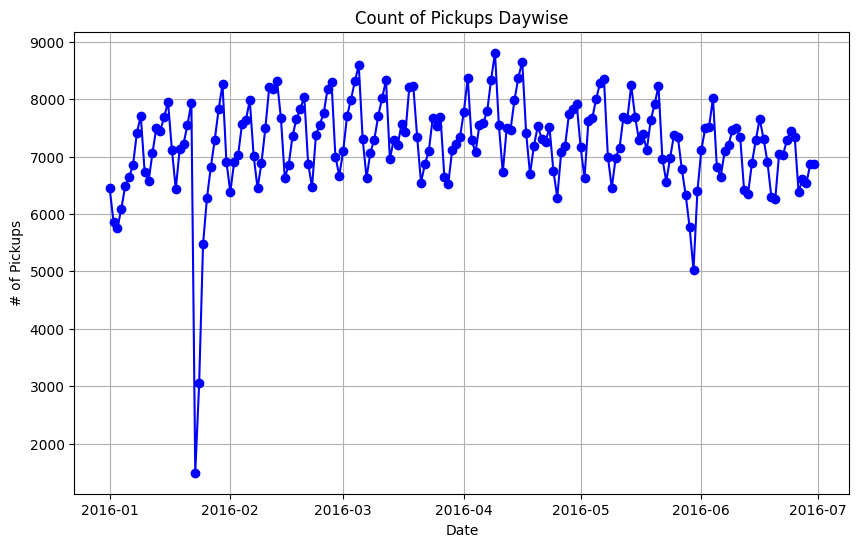

In [6]:
# Group by day and count occurrences
daily_counts = X_train.groupby(X_train['pickup_datetime'].dt.date).size()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('# of Pickups')
plt.title('Count of Pickups Daywise') 
plt.grid(True)
plt.show()

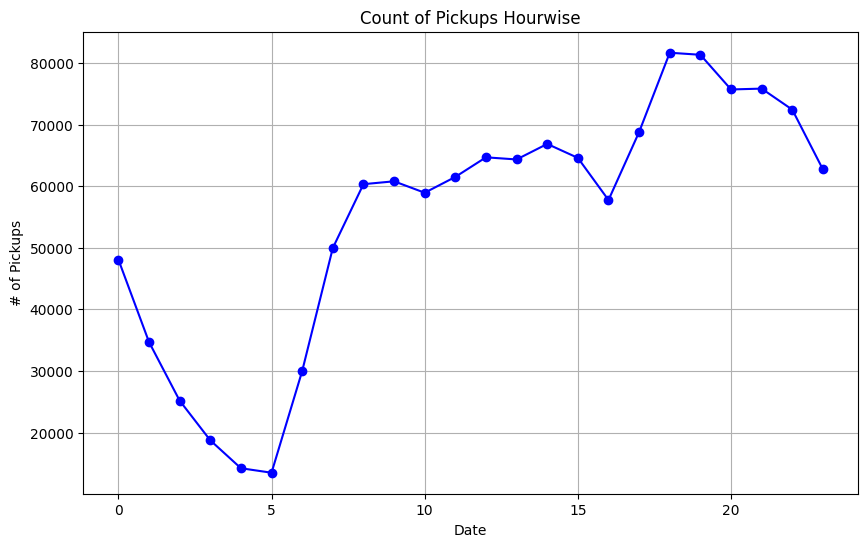

In [7]:
# Group by day and count occurrences
hourly_counts = X_train.groupby(X_train['pickup_datetime'].dt.hour).size()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('# of Pickups')
plt.title('Count of Pickups Hourwise') 
plt.grid(True)
plt.show()

In [8]:
def extract_datetime_features(df, date_col):
    # Extract year, month, day, day of week, etc.
    df[date_col+'year'] = df[date_col].dt.year
    df[date_col+'month'] = df[date_col].dt.month
    df[date_col+'day'] = df[date_col].dt.day
    df[date_col+'day_of_week'] = df[date_col].dt.dayofweek  # Monday is 0, Sunday is 6

    # Weekend flag
    df[date_col+'is_weekend'] = df[date_col+'day_of_week'].isin([5, 6])  # 1 for weekend, 0 otherwise

    # Time features (hour, minute, etc.)
    df[date_col+'hour'] = df[date_col].dt.hour
    df[date_col+'minute'] = df[date_col].dt.minute

    return df

In [9]:
X_train = extract_datetime_features(X_train, 'pickup_datetime')
X_train = extract_datetime_features(X_train, 'dropoff_datetime')

X_test = extract_datetime_features(X_test, 'pickup_datetime')
X_test = extract_datetime_features(X_test, 'dropoff_datetime')

In [10]:
from geopy.distance import great_circle

def calculate_distance(df):
    df['distance_km'] = df.apply(lambda row: great_circle(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers, axis=1)

    return df

X_train = calculate_distance(X_train)
X_test = calculate_distance(X_test)

In [31]:
X_train['store_and_fwd_flag']=X_train['store_and_fwd_flag'].replace({'N':False,'Y':True})
X_test['store_and_fwd_flag']=X_test['store_and_fwd_flag'].replace({'N':False,'Y':True})

In [32]:
X_train.drop(['id','pickup_datetime','dropoff_datetime'],axis=1,inplace=True)
X_test.drop(['id','pickup_datetime','dropoff_datetime'],axis=1,inplace=True)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

<Axes: >

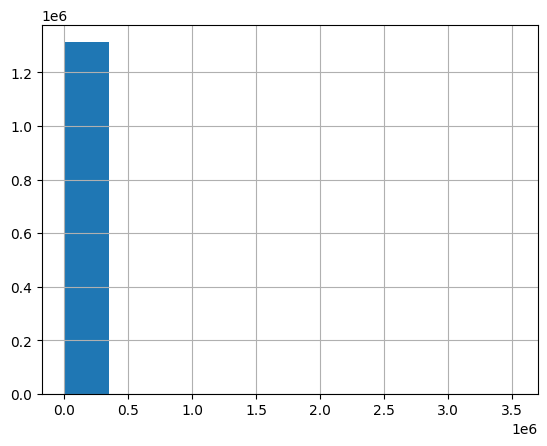

In [26]:
y_train.hist()

In [28]:
y_train_log=np.log(y_train).to_numpy().reshape(-1,1)
y_test_log=np.log(y_test).to_numpy().reshape(-1,1)

array([[<Axes: title={'center': '0'}>]], dtype=object)

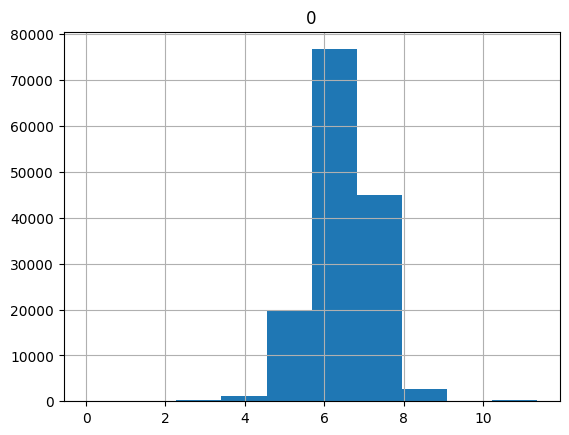

In [29]:
pd.DataFrame(y_test_log).hist()

In [35]:
from sklearn.model_selection import train_test_split

X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_train_scaled, y_train_log, random_state=0, test_size =0.2)

In [36]:
def  build_nn_model(model, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, max_epochs, batch_size, patience, learning_rate):
    # Hyperparameters

    least_val_loss = float('inf')

    train_batch_loss_list=[]
    val_loss_list=[]
    train_loss_list=[]

    for i in range(max_epochs):
        for start_idx in range(0, X_train_scaled.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, X_train_scaled.shape[0])   
            # Getting Batch Size from train data.
            batch_train_X= X_train_scaled[start_idx:end_idx]
            batch_train_Y= y_train_scaled[start_idx:end_idx]
            # Feed forward the training data
            train_output = model.forward(batch_train_X)
            train_loss,train_grad_loss = MeansquaredLoss(train_output, batch_train_Y).calculate_loss_gradient()
            
            # Updating weights
            _ = model.backward(train_grad_loss,learning_rate =learning_rate)
            train_batch_loss_list.append(train_loss)
            
        val_output = model.forward(X_val_scaled)
        val_loss,_ = MeansquaredLoss(val_output, y_val_scaled).calculate_loss_gradient()

        train_loss_list.append(np.mean(train_batch_loss_list))
        val_loss_list.append(val_loss)

        print(f'Epoch {i}, Train Loss: {train_loss_list[-1]} Validation Loss: {val_loss}')

        if val_loss < least_val_loss:
            least_val_loss = val_loss
            no_improve_count = 0
            #best_weight = self.weights
            #best_bias = self.bias
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {i}.")
                break
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_list, label="Model Training Loss", color="green")
    plt.plot(val_loss_list, label="Model Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

d:\UTA\Sem-2\ML\CSE6363\assignments\assignment3\NeuralNetworkModule.py:59: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


Epoch 0, Train Loss: 0.36913438657029607 Validation Loss: 0.2749469611447052
Epoch 1, Train Loss: 0.3152258424856853 Validation Loss: 0.2506052500663452
Epoch 2, Train Loss: 0.2909614778452164 Validation Loss: 0.23658141749327455
Epoch 3, Train Loss: 0.27400190011597536 Validation Loss: 0.20836687537366297
Epoch 4, Train Loss: 0.25475476573263695 Validation Loss: 0.16080947565659828
Epoch 5, Train Loss: 0.2362696830843906 Validation Loss: 0.13062667453585947
Epoch 6, Train Loss: 0.22011995564639575 Validation Loss: 0.13108748042604573
Epoch 7, Train Loss: 0.20634962862010164 Validation Loss: 0.1368394644566935
Epoch 8, Train Loss: 0.19463253806890457 Validation Loss: 0.12575054717348058
Epoch 9, Train Loss: 0.1845228893394377 Validation Loss: 0.11644343650335026
Epoch 10, Train Loss: 0.17565326254408883 Validation Loss: 0.10477849216981021
Epoch 11, Train Loss: 0.16776874505610795 Validation Loss: 0.09154914177366925
Epoch 12, Train Loss: 0.1606844281516902 Validation Loss: 0.079544627

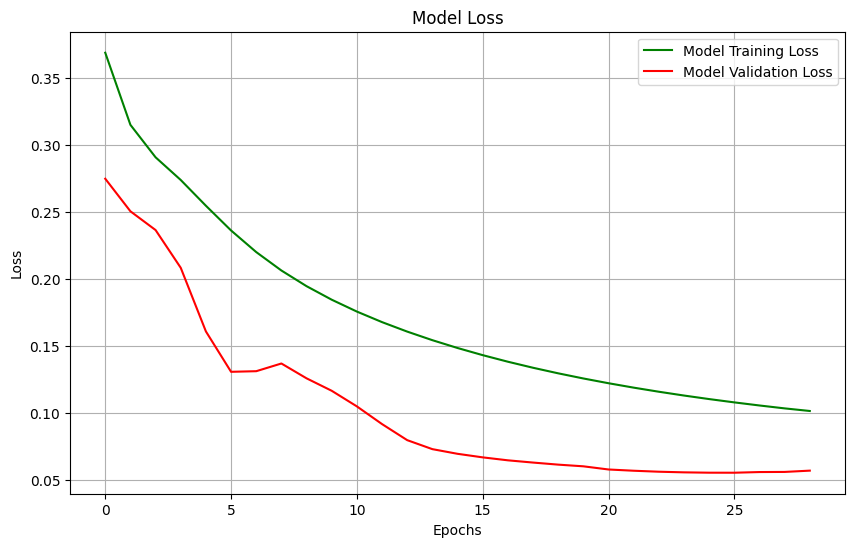

Test RMSLE: 0.24459998760990165


In [37]:
# Architecture 1

# Build the neural network
model = Sequential([
    Linear(X_train_scaled.shape[1], 25),
    Sigmoid(),
    Linear(25, 10),
    Sigmoid(),
    Linear(10, 1),

])    

# Hyperparameters
max_epochs=50
batch_size=512
patience=3
learning_rate=1e-2

trained_model= build_nn_model(model, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, max_epochs, batch_size, patience, learning_rate)

test_pred = trained_model.forward(X_test_scaled)
print(f"Test RMSLE: {rmsle(y_test.to_numpy().reshape(-1,1),np.exp(test_pred))}")



Epoch 0, Train Loss: 1.0299997139858943e+195 Validation Loss: 0.638071844326788
Epoch 1, Train Loss: 5.1499985699294715e+194 Validation Loss: 0.638071844326788
Epoch 2, Train Loss: 3.4333323799529814e+194 Validation Loss: 0.638071844326788
Epoch 3, Train Loss: 2.5749992849647358e+194 Validation Loss: 0.638071844326788
Early stopping at epoch 3.


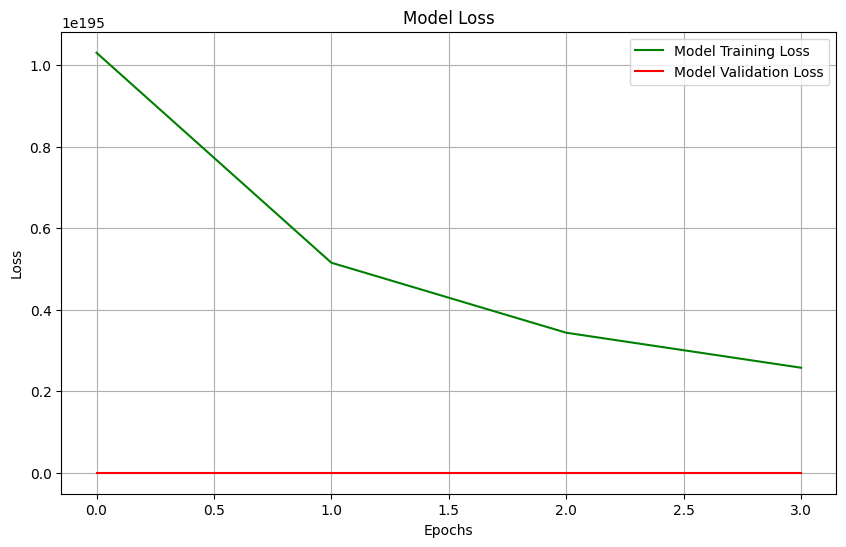

Test RMSLE: 0.7993305898318238


In [38]:
# Architecture 2

# Build the neural network
model = Sequential([
    Linear(X_train_scaled.shape[1], 25),
    ReLU(),
    Linear(25, 10),
    ReLU(),
    Linear(10, 1),

])    

# Hyperparameters
max_epochs=50
batch_size=512
patience=3
learning_rate=1e-4

trained_model= build_nn_model(model, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, max_epochs, batch_size, patience, learning_rate)

test_pred = trained_model.forward(X_test_scaled)
print(f"Test RMSLE: {rmsle(y_test.to_numpy().reshape(-1,1),np.exp(test_pred))}")

Epoch 0, Train Loss: 1.2872753030511923 Validation Loss: 0.3904759746490506
Epoch 1, Train Loss: 0.8108795626052532 Validation Loss: 0.3570858782937159
Epoch 2, Train Loss: 0.6400828604283424 Validation Loss: 0.27887336418169384
Epoch 3, Train Loss: 0.5465943944242824 Validation Loss: 0.214907138416687
Epoch 4, Train Loss: 0.4812488548685223 Validation Loss: 0.19924766976209557
Epoch 5, Train Loss: 0.4322170835577488 Validation Loss: 0.16742521210821035
Epoch 6, Train Loss: 0.39310356127593094 Validation Loss: 0.10398853315778457
Epoch 7, Train Loss: 0.36137031069358444 Validation Loss: 0.24136130204495104
Epoch 8, Train Loss: 0.3355199863908394 Validation Loss: 0.2244799946651886
Epoch 9, Train Loss: 0.31418619769065026 Validation Loss: 0.215058159061271
Early stopping at epoch 9.


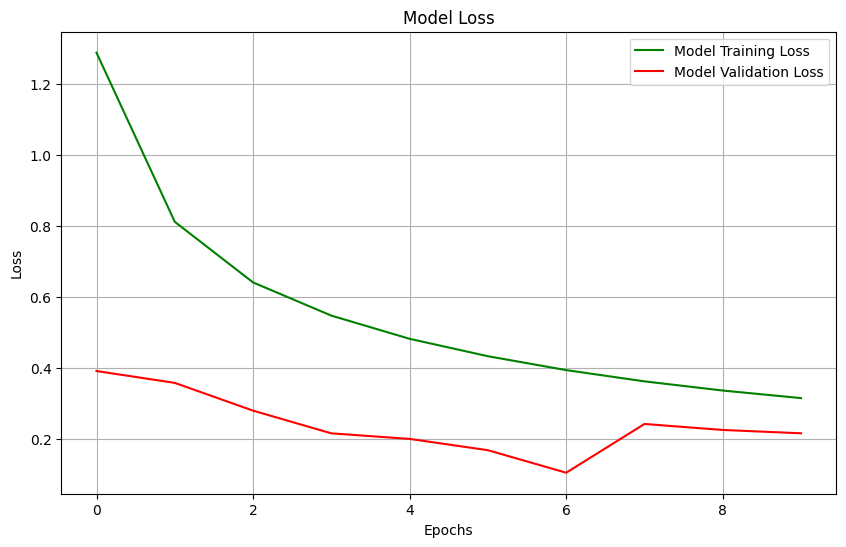

Test RMSLE: 0.46873612609179643


In [39]:
# Architecture 3

# Build the neural network
model = Sequential([
    Linear(X_train_scaled.shape[1], 25),
    Sigmoid(),
    Linear(25, 50),
    Sigmoid(),
    Linear(50, 100),
    Sigmoid(),
    Linear(100, 25),
    Sigmoid(),
    Linear(25, 1),
])    

# Hyperparameters
max_epochs=50
batch_size=512
patience=3
learning_rate=1e-2

trained_model= build_nn_model(model, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, max_epochs, batch_size, patience, learning_rate)

test_pred = trained_model.forward(X_test_scaled)
print(f"Test RMSLE: {rmsle(y_test.to_numpy().reshape(-1,1),np.exp(test_pred))}")